In [1]:
%matplotlib inline


# LDA Model

Introduces Gensim's LDA model and demonstrates its use on the NIPS corpus.


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[Explanation:Logging]('https://docs.python.org/3/howto/logging.html')

The purpose of this tutorial is to demonstrate how to train and tune an LDA model.

In this tutorial we will:

* Load input data.
* Pre-process that data.
* Transform documents into bag-of-words vectors.
* Train an LDA model.

This tutorial will **not**:

* Explain how Latent Dirichlet Allocation works
* Explain how the LDA model performs inference
* Teach you all the parameters and options for Gensim's LDA implementation

If you are not familiar with the LDA model or how to use it in Gensim, I (Olavur Mortensen)
suggest you read up on that before continuing with this tutorial. Basic
understanding of the LDA model should suffice. Examples:

* `Introduction to Latent Dirichlet Allocation <http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation>`_
* Gensim tutorial: `sphx_glr_auto_examples_core_run_topics_and_transformations.py`
* Gensim's LDA model API docs: :py:class:`gensim.models.LdaModel`

I would also encourage you to consider each step when applying the model to
your data, instead of just blindly applying my solution. The different steps
will depend on your data and possibly your goal with the model.

## Data

I have used a corpus of NIPS papers in this tutorial, but if you're following
this tutorial just to learn about LDA I encourage you to consider picking a
corpus on a subject that you are familiar with. Qualitatively evaluating the
output of an LDA model is challenging and can require you to understand the
subject matter of your corpus (depending on your goal with the model).

NIPS (Neural Information Processing Systems) is a machine learning conference
so the subject matter should be well suited for most of the target audience
of this tutorial.  You can download the original data from Sam Roweis'
`website <http://www.cs.nyu.edu/~roweis/data.html>`_.  The code below will
also do that for you.

.. Important::
    The corpus contains 1740 documents, and not particularly long ones.
    So keep in mind that this tutorial is not geared towards efficiency, and be
    careful before applying the code to a large dataset.




In [59]:
import warnings
warnings.simplefilter('ignore')

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
import io
import os.path
import re
import tarfile

import smart_open

def extract_documents(url='https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz'):
    with smart_open.open(url, "rb") as file:
        with tarfile.open(fileobj=file) as tar:
            for member in tar.getmembers():
                if member.isfile() and re.search(r'nipstxt/nips\d+/\d+\.txt', member.name):
                    member_bytes = tar.extractfile(member).read()
                    yield member_bytes.decode('utf-8', errors='replace')

docs = list(extract_documents())

So we have a list of 1740 documents, where each document is a Unicode string.
If you're thinking about using your own corpus, then you need to make sure
that it's in the same format (list of Unicode strings) before proceeding
with the rest of this tutorial.




In [25]:
print(len(docs))
print(docs[0][:500])

1740
387 
Neural Net and Traditional Classifiers  
William Y. Huang and Richard P. Lippmann 
MIT Lincoln Laboratory 
Lexington, MA 02173, USA 
Abstract
Previous work on nets with continuous-valued inputs led to generative 
procedures to construct convex decision regions with two-layer percepttons (one hidden 
layer) and arbitrary decision regions with three-layer percepttons (two hidden layers). 
Here we demonstrate that two-layer perceptton classifiers trained with back propagation 
can form both c


## Pre-process and vectorize the documents

As part of preprocessing, we will:

* Tokenize (split the documents into tokens).
* Lemmatize the tokens.
* Compute bigrams.
* Compute a bag-of-words representation of the data.

First we tokenize the text using a regular expression tokenizer from NLTK. We
remove numeric tokens and tokens that are only a single character, as they
don't tend to be useful, and the dataset contains a lot of them.

.. Important::

   This tutorial uses the nltk library for preprocessing, although you can
   replace it with something else if you want.




In [26]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [27]:
docs[0:5]

[['neural',
  'net',
  'and',
  'traditional',
  'classifiers',
  'william',
  'huang',
  'and',
  'richard',
  'lippmann',
  'mit',
  'lincoln',
  'laboratory',
  'lexington',
  'ma',
  'usa',
  'abstract',
  'previous',
  'work',
  'on',
  'nets',
  'with',
  'continuous',
  'valued',
  'inputs',
  'led',
  'to',
  'generative',
  'procedures',
  'to',
  'construct',
  'convex',
  'decision',
  'regions',
  'with',
  'two',
  'layer',
  'percepttons',
  'one',
  'hidden',
  'layer',
  'and',
  'arbitrary',
  'decision',
  'regions',
  'with',
  'three',
  'layer',
  'percepttons',
  'two',
  'hidden',
  'layers',
  'here',
  'we',
  'demonstrate',
  'that',
  'two',
  'layer',
  'perceptton',
  'classifiers',
  'trained',
  'with',
  'back',
  'propagation',
  'can',
  'form',
  'both',
  'convex',
  'and',
  'disjoint',
  'decision',
  'regions',
  'such',
  'classifiers',
  'are',
  'robust',
  'train',
  'rapidly',
  'and',
  'provide',
  'good',
  'performance',
  'with',
  'simp

We use the WordNet lemmatizer from NLTK. A lemmatizer is preferred over a
stemmer in this case because it produces more readable words. Output that is
easy to read is very desirable in topic modelling.




In [28]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

We find bigrams in the documents. Bigrams are sets of two adjacent words.
Using bigrams we can get phrases like "machine_learning" in our output
(spaces are replaced with underscores); without bigrams we would only get
"machine" and "learning".

Note that in the code below, we find bigrams and then add them to the
original data, because we would like to keep the words "machine" and
"learning" as well as the bigram "machine_learning".

.. Important::
    Computing n-grams of large dataset can be very computationally
    and memory intensive.




In [29]:
docs[0:50]

[['neural',
  'net',
  'and',
  'traditional',
  'classifier',
  'william',
  'huang',
  'and',
  'richard',
  'lippmann',
  'mit',
  'lincoln',
  'laboratory',
  'lexington',
  'ma',
  'usa',
  'abstract',
  'previous',
  'work',
  'on',
  'net',
  'with',
  'continuous',
  'valued',
  'input',
  'led',
  'to',
  'generative',
  'procedure',
  'to',
  'construct',
  'convex',
  'decision',
  'region',
  'with',
  'two',
  'layer',
  'percepttons',
  'one',
  'hidden',
  'layer',
  'and',
  'arbitrary',
  'decision',
  'region',
  'with',
  'three',
  'layer',
  'percepttons',
  'two',
  'hidden',
  'layer',
  'here',
  'we',
  'demonstrate',
  'that',
  'two',
  'layer',
  'perceptton',
  'classifier',
  'trained',
  'with',
  'back',
  'propagation',
  'can',
  'form',
  'both',
  'convex',
  'and',
  'disjoint',
  'decision',
  'region',
  'such',
  'classifier',
  'are',
  'robust',
  'train',
  'rapidly',
  'and',
  'provide',
  'good',
  'performance',
  'with',
  'simple',
  'de

In [30]:
# Compute bigrams.
from gensim.models import Phrases
bi_gram = []
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            bi_gram.append(token)            

2021-09-27 19:54:29,635 : INFO : collecting all words and their counts
2021-09-27 19:54:29,638 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-09-27 19:54:44,875 : INFO : collected 1120198 token types (unigram + bigrams) from a corpus of 4629808 words and 1740 sentences
2021-09-27 19:54:44,876 : INFO : merged Phrases<1120198 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
2021-09-27 19:54:44,876 : INFO : Phrases lifecycle event {'msg': 'built Phrases<1120198 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 15.24s', 'datetime': '2021-09-27T19:54:44.876242', 'gensim': '4.0.1', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [31]:
print(len(bi_gram))

324160


In [33]:
print(bi_gram[320000:])

['there_are', 'this_paper', 'committee_member', 'relationship_between', 'cor_relation', 'we_define', 'generated_by', 'drawn_from', 'assume_that', 'xl_x2', 'xi_xj', 'xi_xj', '_fi', 'committee_member', 'where_denotes', 'jensen_inequality', 'better_than', 'we_define', 'we_consider', 'anti_correlated', 'might_be', '__', 'we_have', 'much_better', 'we_have', 'difference_between', 'determined_by', 'le_than', 'improvement_over', 'committee_member', 'correlation_between', 'committee_member', 'we_have', 'correlation_between', 'we_propose', 'committee_member', 'based_on', 'there_are', 'this_paper', 'committee_member', 'trade_off', 'will_be', 'even_though', 'mutual_information', 'xi_xj', 'mutual_information', 'random_variable', 'xi_xj', 'xi_yi', 'xi_xj', 'xi_xj', 'xi_xj', 'will_be', 'mutual_information', 'random_variable', 'ha_been', 'fact_that', 'mutual_information', 'empirical_study', 'time_series', 'mod_el', 'time_scale', 'ha_been', 'determined_by', 'based_on', 'mutual_information', 'hierarchic

We remove rare words and common words based on their *document frequency*.
Below we remove words that appear in less than 20 documents or in more than
50% of the documents. Consider trying to remove words only based on their
frequency, or maybe combining that with this approach.




In [34]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

2021-09-27 19:56:50,832 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-27 19:57:05,292 : INFO : built Dictionary(79429 unique tokens: ['1ooooo', '1st', '25oo', '2o00', '4ooo']...) from 1740 documents (total 4953968 corpus positions)
2021-09-27 19:57:05,294 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(79429 unique tokens: ['1ooooo', '1st', '25oo', '2o00', '4ooo']...) from 1740 documents (total 4953968 corpus positions)", 'datetime': '2021-09-27T19:57:05.294853', 'gensim': '4.0.1', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-09-27 19:57:05,751 : INFO : discarding 70785 tokens: [('1ooooo', 1), ('25oo', 2), ('2o00', 6), ('4ooo', 2), ('64k', 6), ('a', 1740), ('aaditional', 1), ('above', 1114), ('abstract', 1740), ('acase', 1)]...
2021-09-27 19:57:05,752 : INFO : keeping 8644 tokens which were in no less than 20 and no more than 870 (=50.0%) documents

In [35]:
len(dict(dictionary))

8644

In [36]:
dict(dictionary)

{0: '1st',
 1: '5oo',
 2: '7th',
 3: 'a2',
 4: 'a_well',
 5: 'able',
 6: 'adapting',
 7: 'addition',
 8: 'adjust',
 9: 'adjusted',
 10: 'advanced',
 11: 'agency',
 12: 'air',
 13: 'air_force',
 14: 'albus',
 15: 'along',
 16: 'alter',
 17: 'alternately',
 18: 'alternative',
 19: 'american',
 20: 'american_institute',
 21: 'amount',
 22: 'another',
 23: 'appeared',
 24: 'april',
 25: 'arbitrary',
 26: 'architecture',
 27: 'area',
 28: 'arrow',
 29: 'assigned',
 30: 'associative',
 31: 'assp',
 32: 'asymptotic',
 33: 'attained',
 34: 'attempt',
 35: 'august',
 36: 'author',
 37: 'automatically',
 38: 'available',
 39: 'averaged',
 40: 'b2',
 41: 'back',
 42: 'back_prop',
 43: 'back_propagation',
 44: 'because_they',
 45: 'before',
 46: 'behavior',
 47: 'belong',
 48: 'best',
 49: 'better',
 50: 'better_than',
 51: 'bin',
 52: 'bl',
 53: 'book',
 54: 'boolean',
 55: 'bottom',
 56: 'boundary',
 57: 'bp',
 58: 'brain',
 59: 'break',
 60: 'burr',
 61: 'calculate',
 62: 'called',
 63: 'capabi

Finally, we transform the documents to a vectorized form. We simply compute
the frequency of each word, including the bigrams.




In [37]:
len(docs)

1740

In [38]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [39]:
corpus[2:5]

[[(4, 4),
  (7, 4),
  (8, 2),
  (10, 2),
  (19, 3),
  (20, 1),
  (21, 1),
  (22, 2),
  (26, 1),
  (27, 3),
  (30, 1),
  (34, 1),
  (38, 3),
  (39, 3),
  (41, 1),
  (45, 1),
  (46, 1),
  (49, 3),
  (53, 1),
  (55, 1),
  (58, 2),
  (62, 1),
  (72, 1),
  (77, 7),
  (78, 3),
  (82, 3),
  (84, 1),
  (85, 3),
  (88, 5),
  (91, 4),
  (92, 5),
  (93, 1),
  (94, 1),
  (100, 2),
  (107, 5),
  (108, 8),
  (109, 1),
  (125, 1),
  (128, 1),
  (131, 2),
  (135, 1),
  (136, 4),
  (142, 1),
  (143, 5),
  (145, 2),
  (150, 1),
  (151, 1),
  (152, 1),
  (155, 1),
  (162, 1),
  (163, 1),
  (168, 1),
  (172, 1),
  (182, 3),
  (183, 2),
  (186, 20),
  (187, 7),
  (190, 4),
  (201, 1),
  (202, 1),
  (203, 1),
  (204, 14),
  (206, 3),
  (214, 2),
  (220, 1),
  (225, 1),
  (230, 1),
  (234, 1),
  (244, 2),
  (248, 1),
  (249, 5),
  (250, 2),
  (252, 1),
  (254, 2),
  (261, 1),
  (262, 3),
  (264, 1),
  (271, 1),
  (282, 1),
  (284, 11),
  (287, 1),
  (288, 1),
  (290, 2),
  (298, 3),
  (299, 5),
  (300, 1),
 

Let's see how many tokens and documents we have to train on.




In [40]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 8644
Number of documents: 1740


## Training

We are ready to train the LDA model. We will first discuss how to set some of
the training parameters.

First of all, the elephant in the room: how many topics do I need? There is
really no easy answer for this, it will depend on both your data and your
application. I have used 10 topics here because I wanted to have a few topics
that I could interpret and "label", and because that turned out to give me
reasonably good results. You might not need to interpret all your topics, so
you could use a large number of topics, for example 100.

``chunksize`` controls how many documents are processed at a time in the
training algorithm. Increasing chunksize will speed up training, at least as
long as the chunk of documents easily fit into memory. I've set ``chunksize =
2000``, which is more than the amount of documents, so I process all the
data in one go. Chunksize can however influence the quality of the model, as
discussed in Hoffman and co-authors [2], but the difference was not
substantial in this case.

``passes`` controls how often we train the model on the entire corpus.
Another word for passes might be "epochs". ``iterations`` is somewhat
technical, but essentially it controls how often we repeat a particular loop
over each document. It is important to set the number of "passes" and
"iterations" high enough.

I suggest the following way to choose iterations and passes. First, enable
logging (as described in many Gensim tutorials), and set ``eval_every = 1``
in ``LdaModel``. When training the model look for a line in the log that
looks something like this::

   2016-06-21 15:40:06,753 - gensim.models.ldamodel - DEBUG - 68/1566 documents converged within 400 iterations

If you set ``passes = 20`` you will see this line 20 times. Make sure that by
the final passes, most of the documents have converged. So you want to choose
both passes and iterations to be high enough for this to happen.

We set ``alpha = 'auto'`` and ``eta = 'auto'``. Again this is somewhat
technical, but essentially we are automatically learning two parameters in
the model that we usually would have to specify explicitly.




In [41]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

2021-09-27 19:57:45,736 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2021-09-27 19:57:45,745 : INFO : using serial LDA version on this node
2021-09-27 19:57:45,763 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 1740 documents, updating model once every 1740 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2021-09-27 19:57:45,766 : INFO : PROGRESS: pass 0, at document #1740/1740
2021-09-27 19:58:13,095 : INFO : optimized alpha [0.08297424, 0.05271513, 0.08927028, 0.07589069, 0.07776107, 0.085822016, 0.092032194, 0.062266655, 0.07066481, 0.07345364]
2021-09-27 19:58:13,113 : INFO : topic #1 (0.053): 0.008*"image" + 0.007*"classifier" + 0.004*"circuit" + 0.003*"word" + 0.003*"neuron" + 0.003*"response" + 0.003*"map" + 0.003*"layer" + 0.002*"rule" + 0.002*"character"
2021-09-27 19:58:13,116 : INFO : topic #7 (0.062): 0.004*"neur

2021-09-27 19:59:15,274 : INFO : topic #7 (0.038): 0.010*"policy" + 0.010*"action" + 0.007*"optimal" + 0.006*"control" + 0.006*"reinforcement" + 0.005*"reinforcement_learning" + 0.004*"dynamic" + 0.004*"reward" + 0.004*"convergence" + 0.003*"decision"
2021-09-27 19:59:15,277 : INFO : topic #4 (0.049): 0.018*"neuron" + 0.016*"cell" + 0.007*"response" + 0.006*"synaptic" + 0.005*"spike" + 0.005*"activity" + 0.005*"circuit" + 0.005*"firing" + 0.004*"voltage" + 0.004*"signal"
2021-09-27 19:59:15,279 : INFO : topic #2 (0.056): 0.009*"hidden" + 0.006*"hidden_unit" + 0.006*"net" + 0.005*"control" + 0.005*"layer" + 0.004*"generalization" + 0.004*"gradient" + 0.003*"prediction" + 0.003*"architecture" + 0.003*"noise"
2021-09-27 19:59:15,283 : INFO : topic #3 (0.060): 0.007*"class" + 0.005*"mixture" + 0.004*"bound" + 0.004*"sample" + 0.004*"density" + 0.003*"likelihood" + 0.003*"log" + 0.003*"tree" + 0.003*"classification" + 0.003*"node"
2021-09-27 19:59:15,287 : INFO : topic diff=0.204098, rho=0.

2021-09-27 20:00:00,591 : INFO : topic diff=0.164448, rho=0.288675
2021-09-27 20:00:00,616 : INFO : PROGRESS: pass 11, at document #1740/1740
2021-09-27 20:00:08,815 : INFO : optimized alpha [0.033233967, 0.038198207, 0.056068435, 0.059092313, 0.04522701, 0.044811666, 0.037563585, 0.032782696, 0.041711673, 0.046390954]
2021-09-27 20:00:08,832 : INFO : topic #7 (0.033): 0.014*"action" + 0.011*"policy" + 0.009*"reinforcement" + 0.009*"control" + 0.008*"optimal" + 0.006*"reinforcement_learning" + 0.005*"reward" + 0.005*"dynamic" + 0.004*"decision" + 0.004*"environment"
2021-09-27 20:00:08,834 : INFO : topic #0 (0.033): 0.011*"circuit" + 0.009*"analog" + 0.008*"threshold" + 0.006*"chip" + 0.005*"gate" + 0.005*"node" + 0.004*"noise" + 0.004*"bit" + 0.004*"constraint" + 0.004*"element"
2021-09-27 20:00:08,836 : INFO : topic #9 (0.046): 0.008*"matrix" + 0.007*"gaussian" + 0.006*"approximation" + 0.006*"noise" + 0.005*"estimate" + 0.004*"regression" + 0.004*"nonlinear" + 0.004*"variance" + 0.0

2021-09-27 20:00:49,499 : INFO : topic #9 (0.050): 0.008*"matrix" + 0.007*"gaussian" + 0.007*"noise" + 0.007*"approximation" + 0.005*"estimate" + 0.004*"regression" + 0.004*"nonlinear" + 0.004*"variance" + 0.004*"optimal" + 0.004*"dynamic"
2021-09-27 20:00:49,504 : INFO : topic #2 (0.060): 0.012*"hidden" + 0.008*"hidden_unit" + 0.007*"net" + 0.006*"layer" + 0.006*"generalization" + 0.005*"gradient" + 0.004*"prediction" + 0.004*"trained" + 0.004*"architecture" + 0.004*"back"
2021-09-27 20:00:49,507 : INFO : topic #3 (0.061): 0.008*"class" + 0.006*"mixture" + 0.005*"bound" + 0.005*"sample" + 0.005*"tree" + 0.004*"log" + 0.004*"likelihood" + 0.004*"density" + 0.004*"xi" + 0.004*"em"
2021-09-27 20:00:49,511 : INFO : topic diff=0.113396, rho=0.235702
2021-09-27 20:00:49,528 : INFO : PROGRESS: pass 17, at document #1740/1740
2021-09-27 20:00:57,205 : INFO : optimized alpha [0.033885423, 0.04139847, 0.060876884, 0.061591137, 0.0456208, 0.046423618, 0.035833668, 0.031650983, 0.042579662, 0.050

In [42]:
print(id2word)

{0: '1st', 1: '5oo', 2: '7th', 3: 'a2', 4: 'a_well', 5: 'able', 6: 'adapting', 7: 'addition', 8: 'adjust', 9: 'adjusted', 10: 'advanced', 11: 'agency', 12: 'air', 13: 'air_force', 14: 'albus', 15: 'along', 16: 'alter', 17: 'alternately', 18: 'alternative', 19: 'american', 20: 'american_institute', 21: 'amount', 22: 'another', 23: 'appeared', 24: 'april', 25: 'arbitrary', 26: 'architecture', 27: 'area', 28: 'arrow', 29: 'assigned', 30: 'associative', 31: 'assp', 32: 'asymptotic', 33: 'attained', 34: 'attempt', 35: 'august', 36: 'author', 37: 'automatically', 38: 'available', 39: 'averaged', 40: 'b2', 41: 'back', 42: 'back_prop', 43: 'back_propagation', 44: 'because_they', 45: 'before', 46: 'behavior', 47: 'belong', 48: 'best', 49: 'better', 50: 'better_than', 51: 'bin', 52: 'bl', 53: 'book', 54: 'boolean', 55: 'bottom', 56: 'boundary', 57: 'bp', 58: 'brain', 59: 'break', 60: 'burr', 61: 'calculate', 62: 'called', 63: 'capability', 64: 'carefully', 65: 'carlo', 66: 'ce', 67: 'child', 68:

We can compute the topic coherence of each topic. Below we display the
average topic coherence and print the topics in order of topic coherence.

Note that we use the "Umass" topic coherence measure here (see
:py:func:`gensim.models.ldamodel.LdaModel.top_topics`), Gensim has recently
obtained an implementation of the "AKSW" topic coherence measure (see
accompanying blog post, http://rare-technologies.com/what-is-topic-coherence/).

If you are familiar with the subject of the articles in this dataset, you can
see that the topics below make a lot of sense. However, they are not without
flaws. We can see that there is substantial overlap between some topics,
others are hard to interpret, and most of them have at least some terms that
seem out of place. If you were able to do better, feel free to share your
methods on the blog at http://rare-technologies.com/lda-training-tips/ !




In [43]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

2021-09-27 20:01:23,525 : INFO : CorpusAccumulator accumulated stats from 1000 documents


Average topic coherence: -1.1265.
[([(0.01246546, 'hidden'),
   (0.0079897875, 'hidden_unit'),
   (0.0069322046, 'net'),
   (0.0067818267, 'layer'),
   (0.0061065997, 'generalization'),
   (0.005129276, 'gradient'),
   (0.0039406815, 'trained'),
   (0.003910567, 'prediction'),
   (0.0037961993, 'architecture'),
   (0.0037711381, 'back'),
   (0.0037189873, 'training_set'),
   (0.0036468692, 'propagation'),
   (0.0031983005, 'noise'),
   (0.0029503913, 'back_propagation'),
   (0.0027725387, 'solution'),
   (0.0027434048, 'descent'),
   (0.0027184335, 'minimum'),
   (0.002670679, 'control'),
   (0.0024888467, 'learning_rate'),
   (0.0024674353, 'hidden_layer')],
  -0.9549383726806008),
 ([(0.007798412, 'class'),
   (0.005653023, 'mixture'),
   (0.0052747284, 'bound'),
   (0.004712836, 'sample'),
   (0.004664371, 'tree'),
   (0.0042721955, 'log'),
   (0.004002663, 'likelihood'),
   (0.0038839919, 'density'),
   (0.0037351162, 'xi'),
   (0.003651215, 'em'),
   (0.0034587325, 'prior'),
   (0

In [44]:
top_topics

[([(0.01246546, 'hidden'),
   (0.0079897875, 'hidden_unit'),
   (0.0069322046, 'net'),
   (0.0067818267, 'layer'),
   (0.0061065997, 'generalization'),
   (0.005129276, 'gradient'),
   (0.0039406815, 'trained'),
   (0.003910567, 'prediction'),
   (0.0037961993, 'architecture'),
   (0.0037711381, 'back'),
   (0.0037189873, 'training_set'),
   (0.0036468692, 'propagation'),
   (0.0031983005, 'noise'),
   (0.0029503913, 'back_propagation'),
   (0.0027725387, 'solution'),
   (0.0027434048, 'descent'),
   (0.0027184335, 'minimum'),
   (0.002670679, 'control'),
   (0.0024888467, 'learning_rate'),
   (0.0024674353, 'hidden_layer')],
  -0.9549383726806008),
 ([(0.007798412, 'class'),
   (0.005653023, 'mixture'),
   (0.0052747284, 'bound'),
   (0.004712836, 'sample'),
   (0.004664371, 'tree'),
   (0.0042721955, 'log'),
   (0.004002663, 'likelihood'),
   (0.0038839919, 'density'),
   (0.0037351162, 'xi'),
   (0.003651215, 'em'),
   (0.0034587325, 'prior'),
   (0.0034199352, 'node'),
   (0.003411

In [45]:
# Print the Keyword in the 10 topics
pprint(model.print_topics())
doc_lda = model[corpus]

2021-09-27 20:01:46,017 : INFO : topic #0 (0.034): 0.013*"circuit" + 0.011*"analog" + 0.011*"chip" + 0.009*"threshold" + 0.006*"node" + 0.006*"bit" + 0.005*"gate" + 0.005*"vlsi" + 0.005*"implementation" + 0.004*"element"
2021-09-27 20:01:46,020 : INFO : topic #1 (0.043): 0.024*"image" + 0.012*"recognition" + 0.010*"classifier" + 0.007*"classification" + 0.007*"distance" + 0.006*"character" + 0.006*"face" + 0.006*"object" + 0.006*"pixel" + 0.005*"map"
2021-09-27 20:01:46,022 : INFO : topic #2 (0.063): 0.012*"hidden" + 0.008*"hidden_unit" + 0.007*"net" + 0.007*"layer" + 0.006*"generalization" + 0.005*"gradient" + 0.004*"trained" + 0.004*"prediction" + 0.004*"architecture" + 0.004*"back"
2021-09-27 20:01:46,023 : INFO : topic #3 (0.063): 0.008*"class" + 0.006*"mixture" + 0.005*"bound" + 0.005*"sample" + 0.005*"tree" + 0.004*"log" + 0.004*"likelihood" + 0.004*"density" + 0.004*"xi" + 0.004*"em"
2021-09-27 20:01:46,026 : INFO : topic #4 (0.046): 0.024*"neuron" + 0.018*"cell" + 0.008*"spike"

[(0,
  '0.013*"circuit" + 0.011*"analog" + 0.011*"chip" + 0.009*"threshold" + '
  '0.006*"node" + 0.006*"bit" + 0.005*"gate" + 0.005*"vlsi" + '
  '0.005*"implementation" + 0.004*"element"'),
 (1,
  '0.024*"image" + 0.012*"recognition" + 0.010*"classifier" + '
  '0.007*"classification" + 0.007*"distance" + 0.006*"character" + '
  '0.006*"face" + 0.006*"object" + 0.006*"pixel" + 0.005*"map"'),
 (2,
  '0.012*"hidden" + 0.008*"hidden_unit" + 0.007*"net" + 0.007*"layer" + '
  '0.006*"generalization" + 0.005*"gradient" + 0.004*"trained" + '
  '0.004*"prediction" + 0.004*"architecture" + 0.004*"back"'),
 (3,
  '0.008*"class" + 0.006*"mixture" + 0.005*"bound" + 0.005*"sample" + '
  '0.005*"tree" + 0.004*"log" + 0.004*"likelihood" + 0.004*"density" + '
  '0.004*"xi" + 0.004*"em"'),
 (4,
  '0.024*"neuron" + 0.018*"cell" + 0.008*"spike" + 0.008*"synaptic" + '
  '0.007*"response" + 0.006*"firing" + 0.006*"activity" + 0.005*"signal" + '
  '0.005*"connection" + 0.004*"potential"'),
 (5,
  '0.013*"vi

### Visualisation

In [46]:
from itertools import chain
import pyLDAvis
import pyLDAvis.gensim_models #LDA visualization library

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\pandas\_testing.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import pandas._libs.testing as _testing
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [47]:
lda_display = pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
2021-09-27 20:02:44,541 : INFO : NumExpr defaulting to 4 threads.
C:\Users\Admin\AppData\Roaming\Python\Python3

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif

### Compute model perplexity and coherence score

In [52]:
print('\nPerplexity: ', model.log_perplexity(corpus,total_docs=1740))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=model, texts=docs, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-09-27 20:14:36,393 : INFO : -7.961 per-word bound, 249.1 perplexity estimate based on a held-out corpus of 1740 documents with 2045380 words
2021-09-27 20:14:36,404 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows



Perplexity:  -7.960539790560658


2021-09-27 20:14:40,282 : INFO : 1 batches submitted to accumulate stats from 64 documents (204107 virtual)
2021-09-27 20:14:40,380 : INFO : 2 batches submitted to accumulate stats from 128 documents (397529 virtual)
2021-09-27 20:14:40,485 : INFO : 3 batches submitted to accumulate stats from 192 documents (557013 virtual)
2021-09-27 20:14:40,613 : INFO : 4 batches submitted to accumulate stats from 256 documents (728476 virtual)
2021-09-27 20:14:40,705 : INFO : 5 batches submitted to accumulate stats from 320 documents (880394 virtual)
2021-09-27 20:14:40,822 : INFO : 6 batches submitted to accumulate stats from 384 documents (1039695 virtual)
2021-09-27 20:14:46,431 : INFO : 7 batches submitted to accumulate stats from 448 documents (1195752 virtual)
2021-09-27 20:14:47,754 : INFO : 8 batches submitted to accumulate stats from 512 documents (1369720 virtual)
2021-09-27 20:14:48,098 : INFO : 9 batches submitted to accumulate stats from 576 documents (1534487 virtual)
2021-09-27 20:14


Coherence Score:  0.5089334857121872


In [55]:
c_value = [c[1] for c in top_topics]

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Admin\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


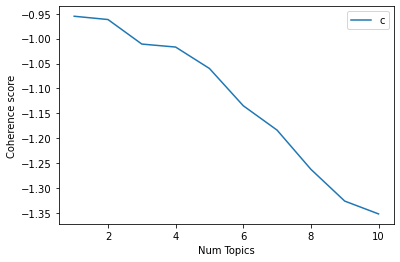

In [58]:
import matplotlib.pyplot as plt
# Show graph
limit=11; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, c_value)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

## Things to experiment with

* ``no_above`` and ``no_below`` parameters in ``filter_extremes`` method.
* Adding trigrams or even higher order n-grams.
* Consider whether using a hold-out set or cross-validation is the way to go for you.
* Try other datasets.

## Where to go from here

* Check out a RaRe blog post on the AKSW topic coherence measure (http://rare-technologies.com/what-is-topic-coherence/).
* pyLDAvis (https://pyldavis.readthedocs.io/en/latest/index.html).
* Read some more Gensim tutorials (https://github.com/RaRe-Technologies/gensim/blob/develop/tutorials.md#tutorials).
* If you haven't already, read [1] and [2] (see references).

## References

1. "Latent Dirichlet Allocation", Blei et al. 2003.
2. "Online Learning for Latent Dirichlet Allocation", Hoffman et al. 2010.


